# Strategy 3: Long Liquidation Bottom Picker

## Concept
Buy after a washout where longs are capitulating (falling price + falling OI + high volume).
Mass long liquidation often marks capitulation bottoms.

## Strategy Rules
- **Long Entry:** Price falls > 5% over 5 days + OI decreases > 5% over same period + Volume > 2x average + RSI(14) < 30
- **Entry Trigger:** First up-close day after conditions met
- **Exit:** Price reaches 20-day SMA OR new 10-day high
- **Stop Loss:** New low below entry day's low

## Rationale
When longs are forced to liquidate en masse, it creates selling exhaustion.
The combination of falling price + falling OI + high volume signals capitulation.

## Data
- Price: F1_RolledPrice (WTI CL continuous front-month)
- Volume: F1_Volume
- Open Interest: AGG_OI (aggregate across all contracts)

## Cell 1: Imports & Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 10

# Strategy Parameters
PRICE_DROP_PERIOD = 5           # Days to measure price drop
PRICE_DROP_THRESHOLD = 0.05     # Price must fall > 5%
OI_DECLINE_PERIOD = 5           # Days to measure OI decline
OI_DECLINE_THRESHOLD = 0.05     # OI must decline > 5%
VOLUME_MULTIPLIER = 2.0         # Volume must be > 2x 20-day avg
RSI_PERIOD = 14                 # RSI calculation period
RSI_OVERSOLD = 30               # RSI threshold for oversold
SMA_EXIT_PERIOD = 20            # Exit when price reaches 20-day SMA
HIGH_EXIT_LOOKBACK = 10         # Exit at new 10-day high

# Cost assumptions
SLIPPAGE_AND_COMMISSION = 5     # $ per round-trip trade
POINT_VALUE = 1000              # WTI CL contract: $1000 per point

# Data paths
DATA_DIR = Path('../../cache/raw_data')

print("Configuration loaded successfully")
print(f"Strategy: Buy capitulation with Price drop > {PRICE_DROP_THRESHOLD*100}% and OI decline > {OI_DECLINE_THRESHOLD*100}% over {PRICE_DROP_PERIOD} days")
print(f"Entry filter: Volume > {VOLUME_MULTIPLIER}x avg, RSI < {RSI_OVERSOLD}")
print(f"Entry trigger: First up-close day after conditions met")
print(f"Exit: Price reaches {SMA_EXIT_PERIOD}-day SMA or {HIGH_EXIT_LOOKBACK}-day high")

Configuration loaded successfully
Strategy: Buy capitulation with Price drop > 5.0% and OI decline > 5.0% over 5 days
Entry filter: Volume > 2.0x avg, RSI < 30
Entry trigger: First up-close day after conditions met
Exit: Price reaches 20-day SMA or 10-day high


## Cell 2: Load Data

In [2]:
# Load data files
prices_df = pd.read_csv(DATA_DIR / 'prices_db.csv', index_col=0)
oi_df = pd.read_csv(DATA_DIR / 'openinterest_db.csv', index_col=0)
volume_df = pd.read_csv(DATA_DIR / 'volume_db.csv', index_col=0)

# Filter for CL (WTI) only
prices_df = prices_df[prices_df['Name'] == 'CL'].copy()
oi_df = oi_df[oi_df['Name'] == 'CL'].copy()
volume_df = volume_df[volume_df['Name'] == 'CL'].copy()

# Clean volume_df (has an extra header row)
volume_df = volume_df[volume_df['tradeDate'].notna() & (volume_df['tradeDate'] != '')].copy()

# Convert dates
prices_df['tradeDate'] = pd.to_datetime(prices_df['tradeDate'])
oi_df['tradeDate'] = pd.to_datetime(oi_df['tradeDate'])
volume_df['tradeDate'] = pd.to_datetime(volume_df['tradeDate'])

# Merge datasets
df = prices_df[['tradeDate', 'F1_RolledPrice']].merge(
    oi_df[['tradeDate', 'AGG_OI']], on='tradeDate', how='inner'
).merge(
    volume_df[['tradeDate', 'F1_Volume']], on='tradeDate', how='inner'
)

# Sort by date and reset index
df = df.sort_values('tradeDate').reset_index(drop=True)

# Convert to numeric
df['F1_RolledPrice'] = pd.to_numeric(df['F1_RolledPrice'], errors='coerce')
df['AGG_OI'] = pd.to_numeric(df['AGG_OI'], errors='coerce')
df['F1_Volume'] = pd.to_numeric(df['F1_Volume'], errors='coerce')

# Rename columns for clarity
df.columns = ['date', 'price', 'oi', 'volume']

# Drop any rows with missing values
df = df.dropna().reset_index(drop=True)

print(f"Data loaded: {len(df)} rows")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nData preview:")
df.head(10)

Data loaded: 3920 rows
Date range: 2010-01-04 00:00:00 to 2025-07-29 00:00:00

Data preview:


,date,price,oi,volume
0,2010-01-04,104.06,1241859.0,263542.0
1,2010-01-05,104.32,1231436.0,258887.0
2,2010-01-06,105.73,1264706.0,370059.0
3,2010-01-07,105.21,1277089.0,246632.0
4,2010-01-08,105.30,1289625.0,310377.0
5,2010-01-11,105.07,1294224.0,296304.0
6,2010-01-12,103.34,1300867.0,333866.0
7,2010-01-13,102.20,1316280.0,401627.0
8,2010-01-14,101.94,1347402.0,275404.0
9,2010-01-15,100.55,1330155.0,200555.0


## Cell 3: Feature Engineering

In [3]:
# Price change over N days
df['price_change_5d'] = df['price'].pct_change(periods=PRICE_DROP_PERIOD)

# OI change over N days
df['oi_change_5d'] = df['oi'].pct_change(periods=OI_DECLINE_PERIOD)

# 20-day average volume
df['volume_avg_20d'] = df['volume'].rolling(window=20).mean()

# Daily price change (for up-close trigger)
df['daily_return'] = df['price'].pct_change()
df['up_close'] = df['daily_return'] > 0

# RSI(14) calculation
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    # Use exponential moving average for smoother RSI
    avg_gain = gain.ewm(span=period, adjust=False).mean()
    avg_loss = loss.ewm(span=period, adjust=False).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['rsi'] = calculate_rsi(df['price'], RSI_PERIOD)

# 20-day SMA for exit
df['sma_20'] = df['price'].rolling(window=SMA_EXIT_PERIOD).mean()

# 10-day high for exit
df['high_10d'] = df['price'].rolling(window=HIGH_EXIT_LOOKBACK).max()

# Previous day low for stop loss
df['prev_low'] = df['price'].shift(1)  # Using close as proxy for low

# Rolling 5-day low for stop loss reference
df['low_5d'] = df['price'].rolling(window=5).min()

print("Features created:")
print(f"  - price_change_5d: {PRICE_DROP_PERIOD}-day price % change")
print(f"  - oi_change_5d: {OI_DECLINE_PERIOD}-day OI % change")
print(f"  - volume_avg_20d: 20-day average volume")
print(f"  - daily_return: Daily price change")
print(f"  - up_close: Boolean for positive daily close")
print(f"  - rsi: {RSI_PERIOD}-day RSI")
print(f"  - sma_20: {SMA_EXIT_PERIOD}-day SMA (exit target)")
print(f"  - high_10d: {HIGH_EXIT_LOOKBACK}-day high (exit target)")
print(f"  - low_5d: 5-day low (stop loss reference)")
print(f"\nFeature preview:")
df[['date', 'price', 'price_change_5d', 'oi_change_5d', 'rsi', 'sma_20', 'high_10d']].tail(15)

Features created:
  - price_change_5d: 5-day price % change
  - oi_change_5d: 5-day OI % change
  - volume_avg_20d: 20-day average volume
  - daily_return: Daily price change
  - up_close: Boolean for positive daily close
  - rsi: 14-day RSI
  - sma_20: 20-day SMA (exit target)
  - high_10d: 10-day high (exit target)
  - low_5d: 5-day low (stop loss reference)

Feature preview:


,date,price,price_change_5d,oi_change_5d,rsi,sma_20,high_10d
3905,2025-07-09,67.09,0.045667,0.019459,60.193155,66.5335,67.09
3906,2025-07-10,65.28,-0.013301,0.017566,46.495874,66.6950,67.09
3907,2025-07-11,67.16,0.022067,0.038609,57.960751,66.7920,67.16
3908,2025-07-14,65.69,-0.014256,0.047203,48.570774,66.8210,67.16
3909,2025-07-15,65.23,-0.026999,0.039109,45.886634,66.5800,67.16
3910,2025-07-16,65.09,-0.029811,0.026975,45.013086,66.3925,67.16
3911,2025-07-17,66.25,0.014859,0.007474,53.479888,66.1095,67.16
3912,2025-07-18,66.05,-0.016528,-0.008413,51.890365,65.8015,67.16
3913,2025-07-21,65.95,0.003958,-0.030320,51.015589,65.4715,67.16
3914,2025-07-22,65.31,0.001226,-0.026966,45.367714,65.3760,67.16


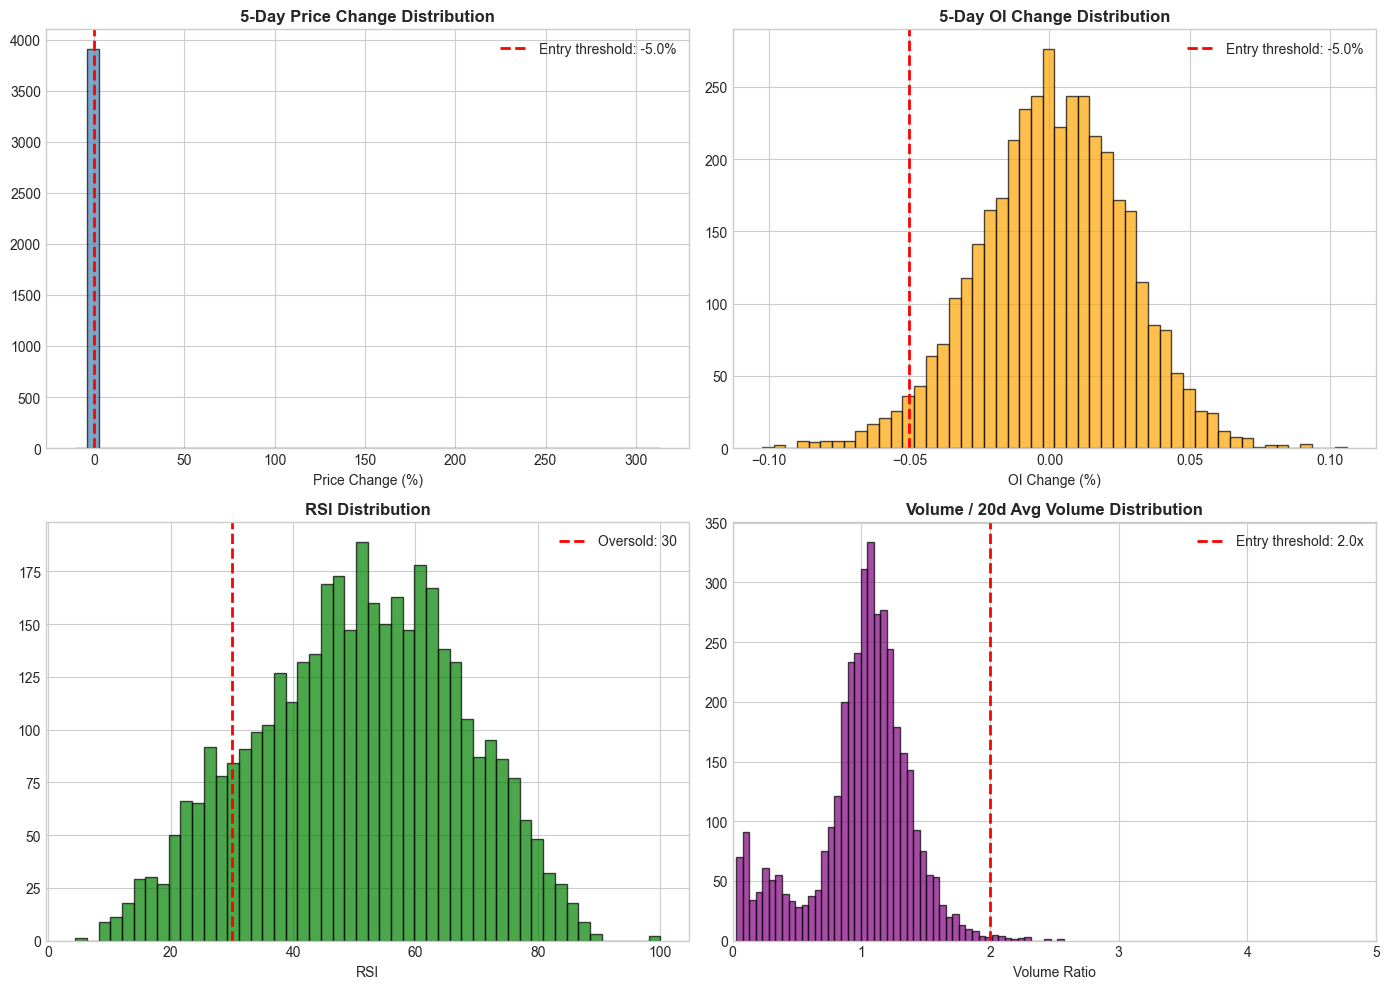


Signal component counts:
  Days with price drop > 5.0%: 646
  Days with OI decline > 5.0%: 118
  Days with RSI < 30: 506
  Days with volume > 2.0x avg: 19


In [4]:
# Distribution of key indicators
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 5-day price change distribution
ax1 = axes[0, 0]
df['price_change_5d'].dropna().hist(bins=50, ax=ax1, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(x=-PRICE_DROP_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Entry threshold: -{PRICE_DROP_THRESHOLD*100}%')
ax1.set_title('5-Day Price Change Distribution', fontweight='bold')
ax1.set_xlabel('Price Change (%)')
ax1.legend()

# 5-day OI change distribution
ax2 = axes[0, 1]
df['oi_change_5d'].dropna().hist(bins=50, ax=ax2, color='orange', edgecolor='black', alpha=0.7)
ax2.axvline(x=-OI_DECLINE_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Entry threshold: -{OI_DECLINE_THRESHOLD*100}%')
ax2.set_title('5-Day OI Change Distribution', fontweight='bold')
ax2.set_xlabel('OI Change (%)')
ax2.legend()

# RSI distribution
ax3 = axes[1, 0]
df['rsi'].dropna().hist(bins=50, ax=ax3, color='green', edgecolor='black', alpha=0.7)
ax3.axvline(x=RSI_OVERSOLD, color='red', linestyle='--', linewidth=2, label=f'Oversold: {RSI_OVERSOLD}')
ax3.set_title('RSI Distribution', fontweight='bold')
ax3.set_xlabel('RSI')
ax3.legend()

# Volume ratio distribution
ax4 = axes[1, 1]
volume_ratio = df['volume'] / df['volume_avg_20d']
volume_ratio.dropna().hist(bins=50, ax=ax4, color='purple', edgecolor='black', alpha=0.7)
ax4.axvline(x=VOLUME_MULTIPLIER, color='red', linestyle='--', linewidth=2, label=f'Entry threshold: {VOLUME_MULTIPLIER}x')
ax4.set_title('Volume / 20d Avg Volume Distribution', fontweight='bold')
ax4.set_xlabel('Volume Ratio')
ax4.set_xlim(0, 5)
ax4.legend()

plt.tight_layout()
plt.show()

# Count potential signals
print("\nSignal component counts:")
print(f"  Days with price drop > {PRICE_DROP_THRESHOLD*100}%: {(df['price_change_5d'] < -PRICE_DROP_THRESHOLD).sum()}")
print(f"  Days with OI decline > {OI_DECLINE_THRESHOLD*100}%: {(df['oi_change_5d'] < -OI_DECLINE_THRESHOLD).sum()}")
print(f"  Days with RSI < {RSI_OVERSOLD}: {(df['rsi'] < RSI_OVERSOLD).sum()}")
print(f"  Days with volume > {VOLUME_MULTIPLIER}x avg: {(df['volume'] > VOLUME_MULTIPLIER * df['volume_avg_20d']).sum()}")

## Cell 4: Signal Generation

In [5]:
# Capitulation conditions (setup)
df['price_crashed'] = df['price_change_5d'] < -PRICE_DROP_THRESHOLD
df['oi_declined'] = df['oi_change_5d'] < -OI_DECLINE_THRESHOLD
df['volume_spike'] = df['volume'] > (VOLUME_MULTIPLIER * df['volume_avg_20d'])
df['rsi_oversold'] = df['rsi'] < RSI_OVERSOLD

# Capitulation setup (all conditions except entry trigger)
df['capitulation_setup'] = (df['price_crashed'] & 
                             df['oi_declined'] & 
                             df['volume_spike'] & 
                             df['rsi_oversold'])

# Entry signal: capitulation setup was true recently AND today is an up-close
# Look back 3 days for setup condition
df['setup_recent'] = df['capitulation_setup'].rolling(window=3, min_periods=1).max().astype(bool)
df['long_signal'] = df['setup_recent'] & df['up_close']

# Avoid consecutive signals - only take first signal after setup
df['signal_group'] = (~df['setup_recent']).cumsum()
df['first_signal_in_group'] = df.groupby('signal_group')['long_signal'].transform(
    lambda x: x & (x.cumsum() == 1)
)
df['long_signal_filtered'] = df['long_signal'] & df['first_signal_in_group']

print("Signal Statistics:")
print(f"  Total trading days: {len(df)}")
print(f"  Days with price crash > {PRICE_DROP_THRESHOLD*100}%: {df['price_crashed'].sum()}")
print(f"  Days with OI decline > {OI_DECLINE_THRESHOLD*100}%: {df['oi_declined'].sum()}")
print(f"  Days with volume > {VOLUME_MULTIPLIER}x avg: {df['volume_spike'].sum()}")
print(f"  Days with RSI < {RSI_OVERSOLD}: {df['rsi_oversold'].sum()}")
print(f"\n  Capitulation setup days (all conditions): {df['capitulation_setup'].sum()}")
print(f"  LONG SIGNALS (setup + up-close trigger): {df['long_signal'].sum()}")
print(f"  FILTERED SIGNALS (first entry per setup): {df['long_signal_filtered'].sum()}")

Signal Statistics:
  Total trading days: 3920
  Days with price crash > 5.0%: 646
  Days with OI decline > 5.0%: 118
  Days with volume > 2.0x avg: 19
  Days with RSI < 30: 506

  Capitulation setup days (all conditions): 0
  LONG SIGNALS (setup + up-close trigger): 0
  FILTERED SIGNALS (first entry per setup): 0


In [6]:
# Preview capitulation setup days
print("\nCapitulation setup days:")
setup_days = df[df['capitulation_setup']][['date', 'price', 'price_change_5d', 'oi_change_5d', 'rsi', 'volume', 'volume_avg_20d']]
print(setup_days.to_string())

print("\n" + "="*50)
print("\nFiltered long signal days (entry points):")
signal_days = df[df['long_signal_filtered']][['date', 'price', 'price_change_5d', 'oi_change_5d', 'rsi', 'daily_return', 'sma_20', 'low_5d']]
print(signal_days.to_string())


Capitulation setup days:
Empty DataFrame
Columns: [date, price, price_change_5d, oi_change_5d, rsi, volume, volume_avg_20d]
Index: []


Filtered long signal days (entry points):
Empty DataFrame
Columns: [date, price, price_change_5d, oi_change_5d, rsi, daily_return, sma_20, low_5d]
Index: []


In [7]:
# If few signals, try relaxing criteria
if df['long_signal_filtered'].sum() < 5:
    print("\n" + "="*50)
    print("Few signals detected. Testing relaxed criteria...")
    print("="*50)
    
    # Test without volume filter
    setup_no_vol = (df['price_crashed'] & df['oi_declined'] & df['rsi_oversold'])
    print(f"\nWithout volume filter: {setup_no_vol.sum()} setup days")
    
    # Test without RSI filter
    setup_no_rsi = (df['price_crashed'] & df['oi_declined'] & df['volume_spike'])
    print(f"Without RSI filter: {setup_no_rsi.sum()} setup days")
    
    # Test with just price crash + OI decline
    setup_core = (df['price_crashed'] & df['oi_declined'])
    print(f"Just price crash + OI decline: {setup_core.sum()} setup days")
    
    # Test with relaxed thresholds
    relaxed_price = df['price_change_5d'] < -0.03  # 3% instead of 5%
    relaxed_oi = df['oi_change_5d'] < -0.03        # 3% instead of 5%
    relaxed_rsi = df['rsi'] < 35                    # 35 instead of 30
    relaxed_vol = df['volume'] > (1.5 * df['volume_avg_20d'])  # 1.5x instead of 2x
    
    setup_relaxed = (relaxed_price & relaxed_oi & relaxed_vol & relaxed_rsi)
    print(f"\nRelaxed thresholds (3%/3%/35 RSI/1.5x vol): {setup_relaxed.sum()} setup days")
    
    # Apply relaxed criteria if needed
    if setup_relaxed.sum() > df['capitulation_setup'].sum():
        print("\n>>> Using relaxed criteria for backtest <<<")
        df['capitulation_setup'] = setup_relaxed
        df['setup_recent'] = df['capitulation_setup'].rolling(window=3, min_periods=1).max().astype(bool)
        df['long_signal'] = df['setup_recent'] & df['up_close']
        df['signal_group'] = (~df['setup_recent']).cumsum()
        df['first_signal_in_group'] = df.groupby('signal_group')['long_signal'].transform(
            lambda x: x & (x.cumsum() == 1)
        )
        df['long_signal_filtered'] = df['long_signal'] & df['first_signal_in_group']
        
        PRICE_DROP_THRESHOLD_USED = 0.03
        OI_DECLINE_THRESHOLD_USED = 0.03
        RSI_OVERSOLD_USED = 35
        VOLUME_MULTIPLIER_USED = 1.5
        print(f"New filtered signal count: {df['long_signal_filtered'].sum()}")
    else:
        PRICE_DROP_THRESHOLD_USED = PRICE_DROP_THRESHOLD
        OI_DECLINE_THRESHOLD_USED = OI_DECLINE_THRESHOLD
        RSI_OVERSOLD_USED = RSI_OVERSOLD
        VOLUME_MULTIPLIER_USED = VOLUME_MULTIPLIER
else:
    PRICE_DROP_THRESHOLD_USED = PRICE_DROP_THRESHOLD
    OI_DECLINE_THRESHOLD_USED = OI_DECLINE_THRESHOLD
    RSI_OVERSOLD_USED = RSI_OVERSOLD
    VOLUME_MULTIPLIER_USED = VOLUME_MULTIPLIER

print(f"\nFinal signal count: {df['long_signal_filtered'].sum()}")


Few signals detected. Testing relaxed criteria...

Without volume filter: 11 setup days
Without RSI filter: 0 setup days
Just price crash + OI decline: 23 setup days

Relaxed thresholds (3%/3%/35 RSI/1.5x vol): 7 setup days

>>> Using relaxed criteria for backtest <<<


New filtered signal count: 5

Final signal count: 5


## Cell 5: Backtest Engine

In [8]:
def run_backtest(df, params):
    """
    Run backtest for long liquidation bottom picker strategy.
    
    Entry: Long signal (capitulation setup + up-close trigger)
    Exit: Price reaches 20-day SMA OR new 10-day high OR Stop loss (5-day low)
    """
    trades = []
    position = 0  # 0 = flat, 1 = long
    entry_price = 0
    entry_date = None
    stop_loss = 0
    
    # Drop rows with NaN in required columns
    required_cols = ['sma_20', 'high_10d', 'low_5d', 'long_signal_filtered']
    df_bt = df.dropna(subset=required_cols).copy()
    df_bt = df_bt.reset_index(drop=True)
    
    for i in range(len(df_bt)):
        row = df_bt.iloc[i]
        price = row['price']
        date = row['date']
        sma_20 = row['sma_20']
        high_10d = row['high_10d']
        
        # If in a long position, check exit conditions
        if position == 1:
            exit_reason = None
            
            # Check stop loss (price <= stop loss level)
            if price <= stop_loss:
                exit_reason = 'stop_loss'
            # Check if price reached 20-day SMA (mean reversion target)
            elif price >= sma_20:
                exit_reason = 'sma_target'
            # Check if price made new 10-day high (momentum exit)
            elif price >= high_10d:
                exit_reason = 'new_high'
            
            # Execute exit
            if exit_reason:
                pnl_points = price - entry_price  # Long: profit when price rises
                pnl_dollars = pnl_points * params['point_value'] - params['costs']
                
                trades.append({
                    'entry_date': entry_date,
                    'exit_date': date,
                    'direction': 'long',
                    'entry_price': entry_price,
                    'exit_price': price,
                    'stop_loss': stop_loss,
                    'pnl_points': pnl_points,
                    'pnl_dollars': pnl_dollars,
                    'exit_reason': exit_reason,
                    'holding_days': (date - entry_date).days
                })
                
                # Reset position
                position = 0
                entry_price = 0
                entry_date = None
                stop_loss = 0
        
        # If flat, check for entry signals
        if position == 0:
            if row['long_signal_filtered']:
                position = 1
                entry_price = price
                entry_date = date
                stop_loss = row['low_5d'] * 0.99  # Stop slightly below 5-day low
    
    # Close any open position at the end
    if position == 1:
        final_price = df_bt.iloc[-1]['price']
        final_date = df_bt.iloc[-1]['date']
        pnl_points = final_price - entry_price
        pnl_dollars = pnl_points * params['point_value'] - params['costs']
        
        trades.append({
            'entry_date': entry_date,
            'exit_date': final_date,
            'direction': 'long',
            'entry_price': entry_price,
            'exit_price': final_price,
            'stop_loss': stop_loss,
            'pnl_points': pnl_points,
            'pnl_dollars': pnl_dollars,
            'exit_reason': 'end_of_data',
            'holding_days': (final_date - entry_date).days
        })
    
    return pd.DataFrame(trades)

# Run backtest
params = {
    'point_value': POINT_VALUE,
    'costs': SLIPPAGE_AND_COMMISSION
}

trades_df = run_backtest(df, params)
print(f"Backtest completed: {len(trades_df)} trades")
if len(trades_df) > 0:
    print("\nTrade details:")
    print(trades_df.to_string())

Backtest completed: 5 trades

Trade details:
  entry_date  exit_date direction  entry_price  exit_price  stop_loss  pnl_points  pnl_dollars exit_reason  holding_days
0 2015-08-12 2015-08-13      long        42.31       41.24    41.6691       -1.07      -1075.0   stop_loss             1
1 2018-10-24 2018-10-31      long        48.79       47.28    47.9160       -1.51      -1515.0   stop_loss             7
2 2021-03-24 2021-04-14      long        32.20       34.17    28.4922        1.97       1965.0  sma_target            21
3 2021-08-10 2021-08-18      long        39.84       37.01    37.6497       -2.83      -2835.0   stop_loss             8
4 2022-06-24 2022-07-05      long        89.06       80.94    84.8529       -8.12      -8125.0   stop_loss            11


## Cell 6: Performance Metrics

In [9]:
def calculate_metrics(trades_df, df, point_value=1000):
    """
    Calculate comprehensive performance metrics.
    """
    if len(trades_df) == 0:
        print("No trades to analyze")
        return None, None, None
    
    # Basic stats
    total_trades = len(trades_df)
    winning_trades = trades_df[trades_df['pnl_dollars'] > 0]
    losing_trades = trades_df[trades_df['pnl_dollars'] <= 0]
    
    win_rate = len(winning_trades) / total_trades if total_trades > 0 else 0
    
    # P&L metrics
    total_pnl = trades_df['pnl_dollars'].sum()
    avg_pnl = trades_df['pnl_dollars'].mean()
    avg_winner = winning_trades['pnl_dollars'].mean() if len(winning_trades) > 0 else 0
    avg_loser = losing_trades['pnl_dollars'].mean() if len(losing_trades) > 0 else 0
    
    # Profit factor
    gross_profit = winning_trades['pnl_dollars'].sum() if len(winning_trades) > 0 else 0
    gross_loss = abs(losing_trades['pnl_dollars'].sum()) if len(losing_trades) > 0 else 0
    profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')
    
    # Holding period
    avg_holding_days = trades_df['holding_days'].mean()
    
    # Calculate equity curve and drawdown
    trades_df_sorted = trades_df.sort_values('exit_date').copy()
    trades_df_sorted['cumulative_pnl'] = trades_df_sorted['pnl_dollars'].cumsum()
    trades_df_sorted['peak'] = trades_df_sorted['cumulative_pnl'].cummax()
    trades_df_sorted['drawdown'] = trades_df_sorted['cumulative_pnl'] - trades_df_sorted['peak']
    max_drawdown = trades_df_sorted['drawdown'].min()
    
    # Calculate date range for annualization
    start_date = df['date'].min()
    end_date = df['date'].max()
    years = (end_date - start_date).days / 365.25
    
    # Annualized return (assuming $100k initial capital)
    initial_capital = 100000
    final_equity = initial_capital + total_pnl
    cagr = (final_equity / initial_capital) ** (1/years) - 1 if years > 0 else 0
    
    # Sharpe ratio (simplified - using trade returns)
    if len(trades_df) > 1:
        returns_std = trades_df['pnl_dollars'].std()
        trades_per_year = total_trades / years
        sharpe = (avg_pnl * trades_per_year) / (returns_std * np.sqrt(trades_per_year)) if returns_std > 0 else 0
    else:
        sharpe = 0
    
    # Exit reason breakdown
    exit_reasons = trades_df['exit_reason'].value_counts().to_dict()
    
    metrics = {
        'Total Trades': total_trades,
        'Win Rate': f"{win_rate:.1%}",
        'Total P&L': f"${total_pnl:,.0f}",
        'Average P&L per Trade': f"${avg_pnl:,.0f}",
        'Average Winner': f"${avg_winner:,.0f}",
        'Average Loser': f"${avg_loser:,.0f}",
        'Profit Factor': f"{profit_factor:.2f}",
        'Max Drawdown': f"${max_drawdown:,.0f}",
        'CAGR': f"{cagr:.1%}",
        'Sharpe Ratio': f"{sharpe:.2f}",
        'Avg Holding Period': f"{avg_holding_days:.1f} days",
        'Test Period': f"{start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}",
        'Years': f"{years:.1f}"
    }
    
    return metrics, trades_df_sorted, exit_reasons

# Calculate metrics
if len(trades_df) > 0:
    metrics, trades_with_equity, exit_reasons = calculate_metrics(trades_df, df, POINT_VALUE)
    
    if metrics:
        print("="*50)
        print("PERFORMANCE METRICS")
        print("="*50)
        for key, value in metrics.items():
            print(f"{key:25s}: {value}")
        
        print("\n" + "="*50)
        print("EXIT REASON BREAKDOWN")
        print("="*50)
        for reason, count in exit_reasons.items():
            print(f"{reason:20s}: {count} trades")
else:
    print("No trades were generated.")
    metrics = None
    trades_with_equity = None
    exit_reasons = None

PERFORMANCE METRICS
Total Trades             : 5
Win Rate                 : 20.0%
Total P&L                : $-11,585
Average P&L per Trade    : $-2,317
Average Winner           : $1,965
Average Loser            : $-3,388
Profit Factor            : 0.15
Max Drawdown             : $-10,960
CAGR                     : -0.8%
Sharpe Ratio             : -0.36
Avg Holding Period       : 9.6 days
Test Period              : 2010-01-04 to 2025-07-29
Years                    : 15.6

EXIT REASON BREAKDOWN
stop_loss           : 4 trades
sma_target          : 1 trades


## Cell 7: Visualizations

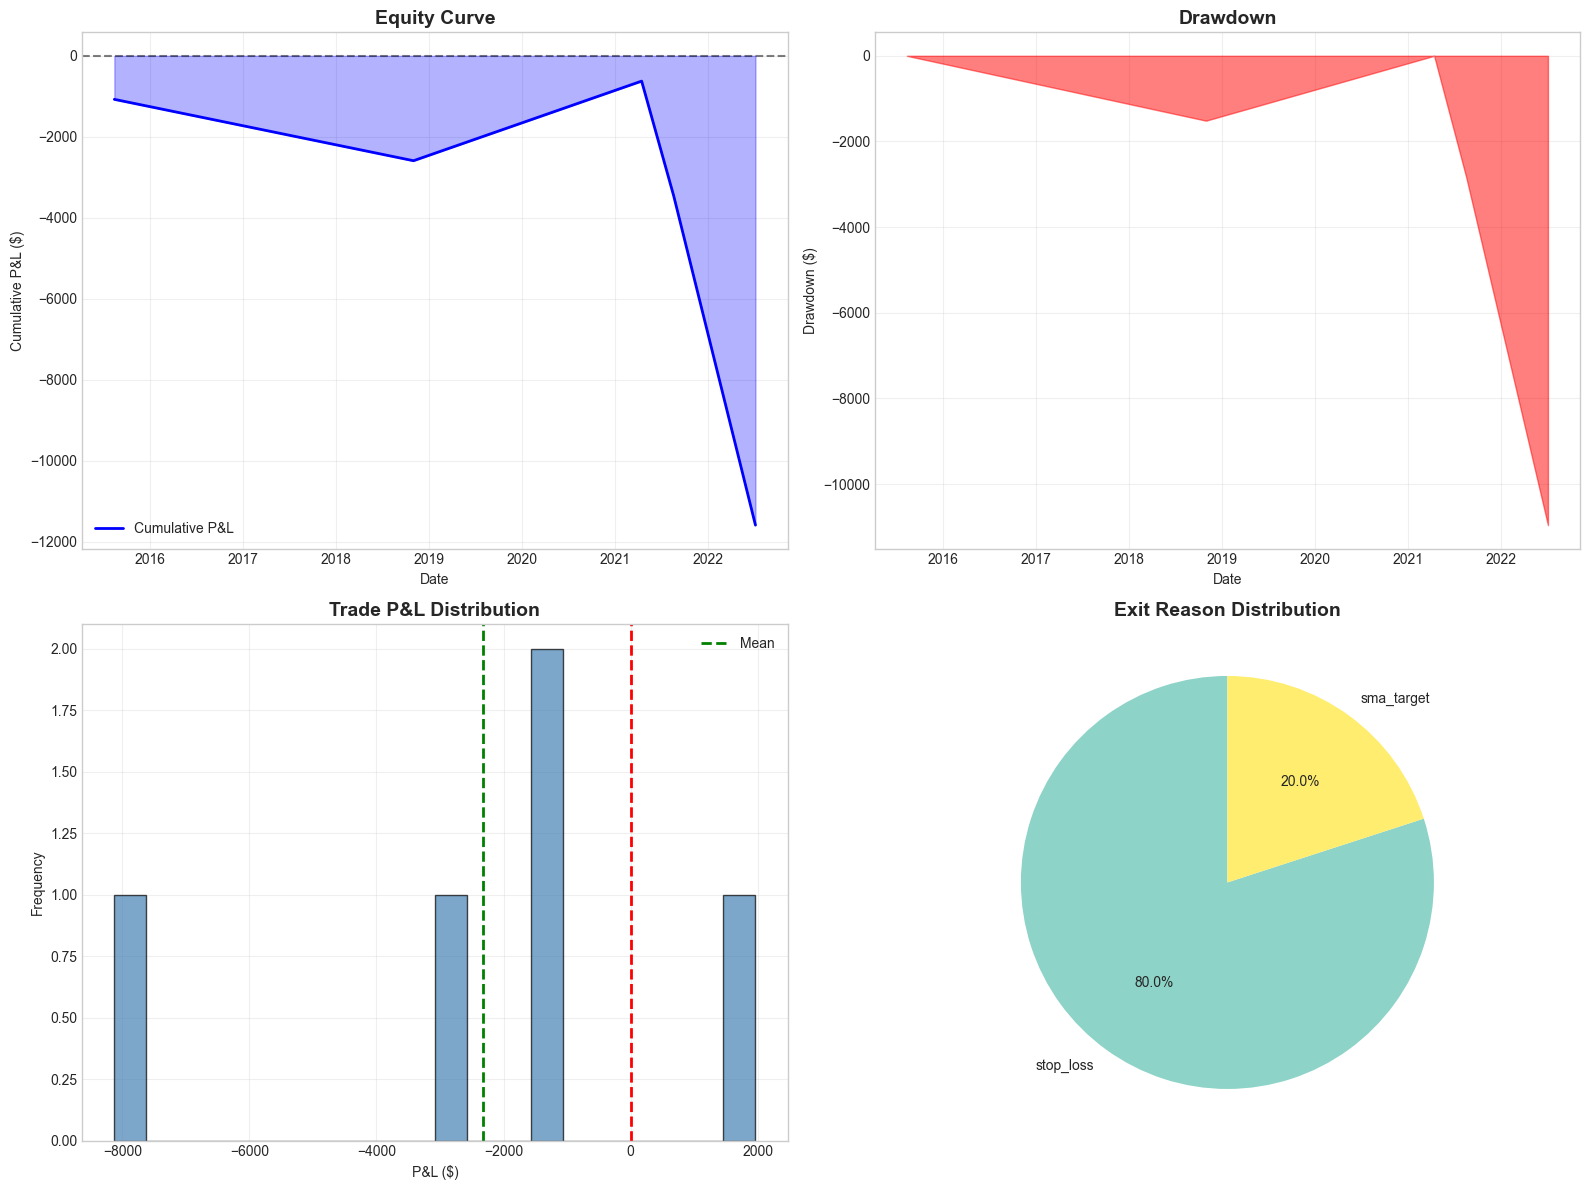

In [10]:
if len(trades_df) > 0 and trades_with_equity is not None:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Equity Curve
    ax1 = axes[0, 0]
    ax1.plot(trades_with_equity['exit_date'], trades_with_equity['cumulative_pnl'], 
             linewidth=2, color='blue', label='Cumulative P&L')
    ax1.fill_between(trades_with_equity['exit_date'], 0, trades_with_equity['cumulative_pnl'],
                     alpha=0.3, color='blue')
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax1.set_title('Equity Curve', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cumulative P&L ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Drawdown
    ax2 = axes[0, 1]
    ax2.fill_between(trades_with_equity['exit_date'], 0, trades_with_equity['drawdown'],
                     color='red', alpha=0.5)
    ax2.set_title('Drawdown', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Drawdown ($)')
    ax2.grid(True, alpha=0.3)
    
    # 3. Trade P&L Distribution
    ax3 = axes[1, 0]
    ax3.hist(trades_df['pnl_dollars'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
    ax3.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax3.axvline(x=trades_df['pnl_dollars'].mean(), color='green', linestyle='--', linewidth=2, label='Mean')
    ax3.set_title('Trade P&L Distribution', fontsize=14, fontweight='bold')
    ax3.set_xlabel('P&L ($)')
    ax3.set_ylabel('Frequency')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Exit Reason Pie Chart
    ax4 = axes[1, 1]
    exit_counts = trades_df['exit_reason'].value_counts()
    colors_pie = plt.cm.Set3(np.linspace(0, 1, len(exit_counts)))
    ax4.pie(exit_counts.values, labels=exit_counts.index, autopct='%1.1f%%', 
            colors=colors_pie, startangle=90)
    ax4.set_title('Exit Reason Distribution', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("No trades to visualize.")

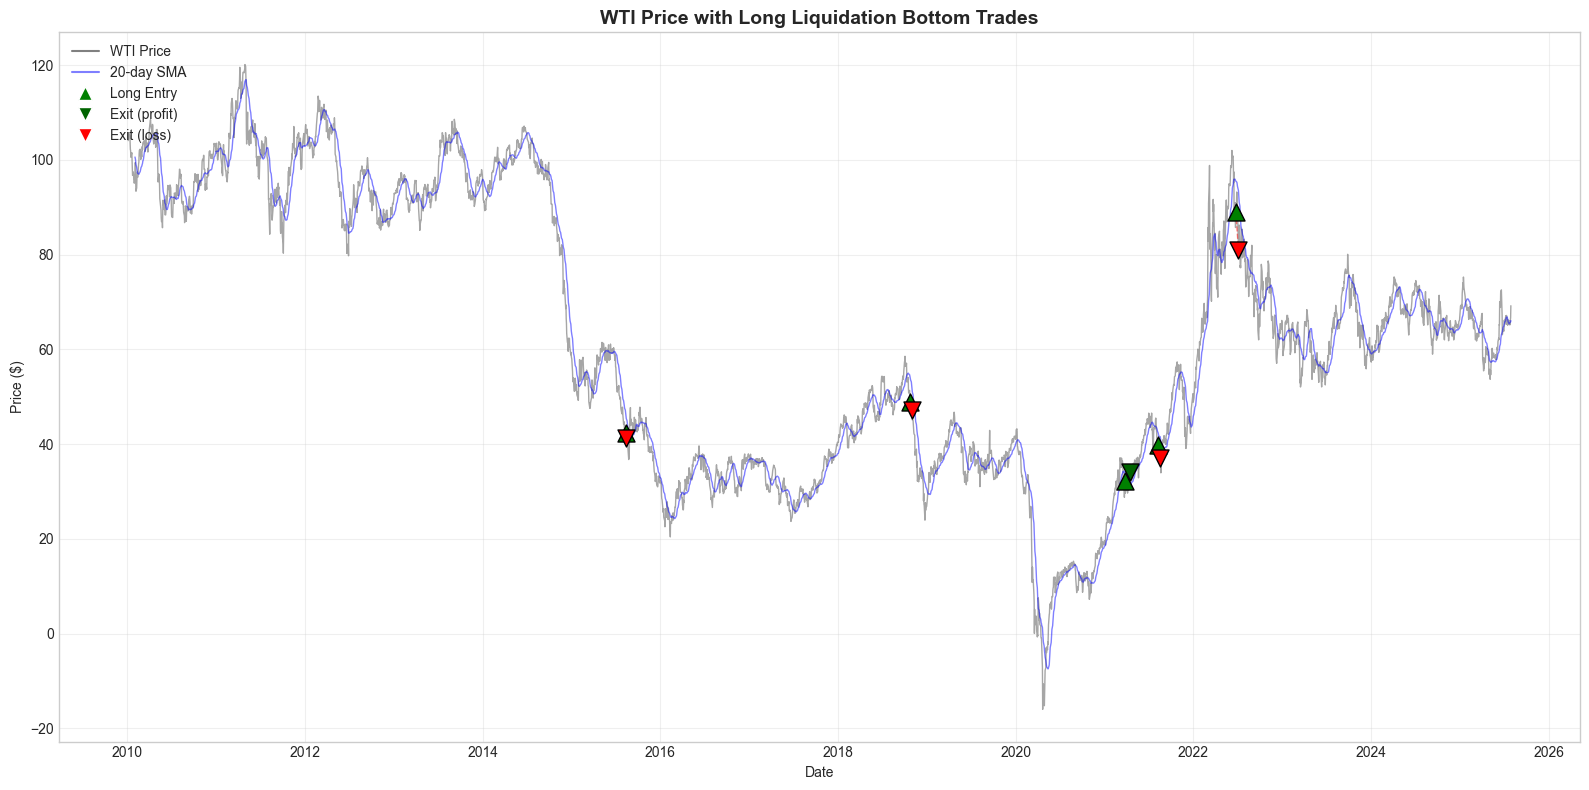

In [11]:
# Price chart with entry/exit points
if len(trades_df) > 0:
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Plot price
    ax.plot(df['date'], df['price'], linewidth=1, color='gray', alpha=0.7, label='WTI Price')
    
    # Plot 20-day SMA
    ax.plot(df['date'], df['sma_20'], linewidth=1, color='blue', alpha=0.5, label='20-day SMA')
    
    # Plot long entries/exits
    for _, trade in trades_df.iterrows():
        # Entry (long)
        ax.scatter(trade['entry_date'], trade['entry_price'], 
                   marker='^', color='green', s=150, zorder=5, edgecolors='black')
        # Exit
        exit_color = 'darkgreen' if trade['pnl_dollars'] > 0 else 'red'
        ax.scatter(trade['exit_date'], trade['exit_price'], 
                   marker='v', color=exit_color, s=150, zorder=5, edgecolors='black')
        
        # Draw line connecting entry and exit
        ax.plot([trade['entry_date'], trade['exit_date']], 
                [trade['entry_price'], trade['exit_price']],
                color=exit_color, linestyle='--', alpha=0.5, linewidth=1)
    
    # Create legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='gray', label='WTI Price'),
        Line2D([0], [0], color='blue', alpha=0.5, label='20-day SMA'),
        Line2D([0], [0], marker='^', color='w', markerfacecolor='green', markersize=10, label='Long Entry'),
        Line2D([0], [0], marker='v', color='w', markerfacecolor='darkgreen', markersize=10, label='Exit (profit)'),
        Line2D([0], [0], marker='v', color='w', markerfacecolor='red', markersize=10, label='Exit (loss)'),
    ]
    ax.legend(handles=legend_elements, loc='upper left')
    
    ax.set_title('WTI Price with Long Liquidation Bottom Trades', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price ($)')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No trades to visualize.")


Yearly P&L Breakdown:
      Total P&L  Avg P&L  Trades
year                            
2015    -1075.0  -1075.0       1
2018    -1515.0  -1515.0       1
2021     -870.0   -435.0       2
2022    -8125.0  -8125.0       1


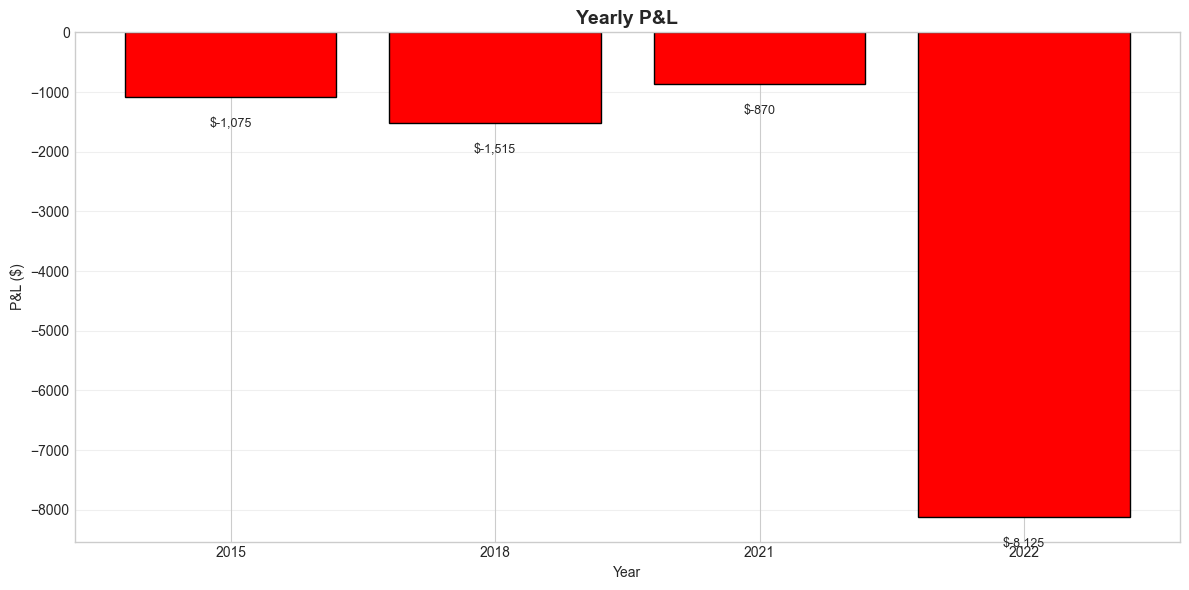

In [12]:
# Yearly P&L breakdown
if len(trades_df) > 0:
    trades_yearly = trades_df.copy()
    trades_yearly['year'] = trades_yearly['exit_date'].dt.year
    
    yearly_stats = trades_yearly.groupby('year').agg({
        'pnl_dollars': ['sum', 'mean', 'count'],
    }).round(0)
    yearly_stats.columns = ['Total P&L', 'Avg P&L', 'Trades']
    
    print("\nYearly P&L Breakdown:")
    print(yearly_stats.to_string())
    
    # Plot yearly P&L
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['green' if x > 0 else 'red' for x in yearly_stats['Total P&L']]
    bars = ax.bar(yearly_stats.index.astype(str), yearly_stats['Total P&L'], color=colors, edgecolor='black')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_title('Yearly P&L', fontsize=14, fontweight='bold')
    ax.set_xlabel('Year')
    ax.set_ylabel('P&L ($)')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, val in zip(bars, yearly_stats['Total P&L']):
        height = bar.get_height()
        ax.annotate(f'${val:,.0f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3 if height > 0 else -15),
                    textcoords="offset points",
                    ha='center', va='bottom' if height > 0 else 'top',
                    fontsize=9)
    
    plt.tight_layout()
    plt.show()

## Cell 8: Summary & Observations

In [13]:
print("="*60)
print("STRATEGY 3: LONG LIQUIDATION BOTTOM PICKER - BACKTEST SUMMARY")
print("="*60)

print("\nStrategy Concept:")
print("  Buy capitulation bottoms (falling price + falling OI + high volume)")
print("  Mass long liquidation often marks selling exhaustion and reversal points.")

print("\nStrategy Parameters Used:")
try:
    print(f"  - Price drop threshold: {PRICE_DROP_THRESHOLD_USED*100}% over 5 days")
    print(f"  - OI decline threshold: {OI_DECLINE_THRESHOLD_USED*100}% over 5 days")
    print(f"  - Volume threshold: {VOLUME_MULTIPLIER_USED}x 20-day average")
    print(f"  - RSI oversold: < {RSI_OVERSOLD_USED}")
except:
    print(f"  - Price drop threshold: {PRICE_DROP_THRESHOLD*100}% over 5 days")
    print(f"  - OI decline threshold: {OI_DECLINE_THRESHOLD*100}% over 5 days")
    print(f"  - Volume threshold: {VOLUME_MULTIPLIER}x 20-day average")
    print(f"  - RSI oversold: < {RSI_OVERSOLD}")
print(f"  - Entry trigger: First up-close day after setup")
print(f"  - Exit: Price reaches 20-day SMA OR 10-day high OR Stop loss at 5-day low")

if len(trades_df) > 0:
    print("\nKey Findings:")
    
    # Win rate analysis
    winners = len(trades_df[trades_df['pnl_dollars'] > 0])
    total = len(trades_df)
    win_rate = winners / total
    
    if win_rate >= 0.5:
        print(f"  + Win rate of {win_rate:.1%} indicates positive edge")
    else:
        print(f"  - Win rate of {win_rate:.1%} below 50%")
    
    # Profit factor
    gross_profit = trades_df[trades_df['pnl_dollars'] > 0]['pnl_dollars'].sum()
    gross_loss = abs(trades_df[trades_df['pnl_dollars'] <= 0]['pnl_dollars'].sum())
    pf = gross_profit / gross_loss if gross_loss > 0 else float('inf')
    
    if pf > 1.5:
        print(f"  + Profit factor of {pf:.2f} is attractive (>1.5)")
    elif pf > 1:
        print(f"  ~ Profit factor of {pf:.2f} is marginally profitable")
    else:
        print(f"  - Profit factor of {pf:.2f} indicates unprofitable strategy")
    
    # Trade frequency
    years = (df['date'].max() - df['date'].min()).days / 365.25
    trades_per_year = len(trades_df) / years
    print(f"  ~ Trade frequency: {trades_per_year:.1f} trades/year")
    
    # Exit analysis
    print("\nExit Analysis:")
    for reason in trades_df['exit_reason'].unique():
        subset = trades_df[trades_df['exit_reason'] == reason]
        avg_pnl = subset['pnl_dollars'].mean()
        win_rate_reason = len(subset[subset['pnl_dollars'] > 0]) / len(subset) if len(subset) > 0 else 0
        print(f"  - {reason}: {len(subset)} trades, avg P&L ${avg_pnl:,.0f}, win rate {win_rate_reason:.0%}")
    
    print("\nPotential Improvements to Test:")
    print("  1. Adjust price/OI thresholds")
    print("  2. Add trend confirmation (wait for higher low)")
    print("  3. Use ATR-based stop loss instead of fixed 5-day low")
    print("  4. Scale into position if price continues lower")
    print("  5. Add time-based exit (max holding period)")
    print("  6. Combine with COT data (commercial positioning)")
else:
    print("\nNo trades generated. Suggestions:")
    print("  1. Relax price drop threshold (try 3% instead of 5%)")
    print("  2. Relax OI decline threshold (try 3% instead of 5%)")
    print("  3. Raise RSI threshold (try 35 instead of 30)")
    print("  4. Reduce volume multiplier (try 1.5x instead of 2x)")

STRATEGY 3: LONG LIQUIDATION BOTTOM PICKER - BACKTEST SUMMARY

Strategy Concept:
  Buy capitulation bottoms (falling price + falling OI + high volume)
  Mass long liquidation often marks selling exhaustion and reversal points.

Strategy Parameters Used:
  - Price drop threshold: 3.0% over 5 days
  - OI decline threshold: 3.0% over 5 days
  - Volume threshold: 1.5x 20-day average
  - RSI oversold: < 35
  - Entry trigger: First up-close day after setup
  - Exit: Price reaches 20-day SMA OR 10-day high OR Stop loss at 5-day low

Key Findings:
  - Win rate of 20.0% below 50%
  - Profit factor of 0.15 indicates unprofitable strategy
  ~ Trade frequency: 0.3 trades/year

Exit Analysis:
  - stop_loss: 4 trades, avg P&L $-3,388, win rate 0%
  - sma_target: 1 trades, avg P&L $1,965, win rate 100%

Potential Improvements to Test:
  1. Adjust price/OI thresholds
  2. Add trend confirmation (wait for higher low)
  3. Use ATR-based stop loss instead of fixed 5-day low
  4. Scale into position if pr

In [14]:
# Trade-by-trade analysis
if len(trades_df) > 0:
    print("\n" + "="*60)
    print("TRADE-BY-TRADE ANALYSIS")
    print("="*60)
    
    for i, trade in trades_df.iterrows():
        result = "WIN" if trade['pnl_dollars'] > 0 else "LOSS"
        print(f"\nTrade {i+1}: {result}")
        print(f"  Entry: {trade['entry_date'].strftime('%Y-%m-%d')} @ ${trade['entry_price']:.2f}")
        print(f"  Exit:  {trade['exit_date'].strftime('%Y-%m-%d')} @ ${trade['exit_price']:.2f} ({trade['exit_reason']})")
        print(f"  P&L: ${trade['pnl_dollars']:,.0f} ({trade['holding_days']} days)")
        print(f"  Stop was at: ${trade['stop_loss']:.2f}")


TRADE-BY-TRADE ANALYSIS

Trade 1: LOSS
  Entry: 2015-08-12 @ $42.31
  Exit:  2015-08-13 @ $41.24 (stop_loss)
  P&L: $-1,075 (1 days)
  Stop was at: $41.67

Trade 2: LOSS
  Entry: 2018-10-24 @ $48.79
  Exit:  2018-10-31 @ $47.28 (stop_loss)
  P&L: $-1,515 (7 days)
  Stop was at: $47.92

Trade 3: WIN
  Entry: 2021-03-24 @ $32.20
  Exit:  2021-04-14 @ $34.17 (sma_target)
  P&L: $1,965 (21 days)
  Stop was at: $28.49

Trade 4: LOSS
  Entry: 2021-08-10 @ $39.84
  Exit:  2021-08-18 @ $37.01 (stop_loss)
  P&L: $-2,835 (8 days)
  Stop was at: $37.65

Trade 5: LOSS
  Entry: 2022-06-24 @ $89.06
  Exit:  2022-07-05 @ $80.94 (stop_loss)
  P&L: $-8,125 (11 days)
  Stop was at: $84.85
